<h1>Classification Modeling and Sentiment Analysis for Walmart Customer Reviews</h1>

<p><b>We are scraping the Walmart customer reviews for different products and classify product reviews into positive and negative using the Multinomial Naive Bayes Classifier.</b></p>


<p></p>

In [1]:
import pandas as pd
import csv
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import random
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier
import json
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, quote, unquote
from time import sleep,time
from random import randint
from pandas.io.json import json_normalize
import numpy as np

In [2]:
reviews_df = pd.read_csv("./product_reviews.csv")
reviews = reviews_df[['id', 'reviews.rating', 'reviews.text', 'reviews.title']]

print("The total number of records are:", reviews.count()['id'])
total_reviews = reviews.count()['id']

The total number of records are: 28332


In [3]:
reviews.head()

,id,reviews.rating,reviews.text,reviews.title
0,AVpgNzjwLJeJML43Kpxn,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...
1,AVpgNzjwLJeJML43Kpxn,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...
2,AVpgNzjwLJeJML43Kpxn,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...
3,AVpgNzjwLJeJML43Kpxn,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...
4,AVpgNzjwLJeJML43Kpxn,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...


In [4]:
sia = SentimentIntensityAnalyzer()
polarity = []

#Extracting all the product reviews and ratings
for index, row in reviews.head(n=total_reviews).iterrows():
    pol_score = sia.polarity_scores(row['reviews.text'])
    score = 0
    #If the value of compound score id greater than 0.4 then consider it as positive review otherwise consider it as
    #negative
    if pol_score['compound'] >= 0.4:
        score = 1
    polarity.append(score)
    
reviews['polarity'] = polarity

reviews.head()

c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,reviews.rating,reviews.text,reviews.title,polarity
0,AVpgNzjwLJeJML43Kpxn,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,0
1,AVpgNzjwLJeJML43Kpxn,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,0
2,AVpgNzjwLJeJML43Kpxn,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,1
3,AVpgNzjwLJeJML43Kpxn,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,1
4,AVpgNzjwLJeJML43Kpxn,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,1


In [5]:
records = []
all_words = []
allowed_pos = ['JJ'] #Consider the words which are adjective

#Remove the words which don't have relevance like ['they', 'I', 'was']
stop_words = list(set(stopwords.words("english"))) 

for index, row in reviews.head(n=total_reviews).iterrows():
    records.append((row['reviews.text'], row['polarity']))
    review = str(row['reviews.text'])
    
    #Clean words are any words lowecase and uppercase but no numbers
    clean_words = re.sub('[^a-zA-Z\s]','', review.lower())
    #Convert sentence into list of words
    tokenize_words = word_tokenize(clean_words)
    #Return the words if it is not in stopwords list
    stopped_words = [word for word in tokenize_words if word not in stop_words]
    #Assign parts of speech to each word
    tagged_words = nltk.pos_tag(stopped_words)
    #Append the word into list if it is an adjective
    for word in tagged_words:
        if word[1] in allowed_pos:
            all_words.append(word[0])

#Select the 2000 most frequently repeated words as bag of words
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:2000]

In [6]:
feature = {}

#Tokenize each sentence and check if the tokenized words are present in bag of words and return a json object
def find_feature(data):
    tokenized_words = word_tokenize(data)
    for word in word_features:
        feature[word] = (word in tokenized_words)
    return feature

In [7]:
features_set = []

#Create a json object for each review to check whether the adjectives in the review are present or not in the bag of words 
#and append them into a list
for (review, polarity) in records:
    review_object = json.dumps(find_feature(str(review)))
    features_set.append((review_object, polarity))                        

In [8]:
training_set = []
y = []

for i in range(0,len(features_set)):
    training_set.append(json.loads(features_set[i][0]))
    y.append(features_set[i][1])

x_train = pd.DataFrame.from_dict(json_normalize(training_set), orient='columns')
y_train = pd.DataFrame({'result': y})

print("The total number of records in training dataset are:", x_train.count()[0])
x_train.head()

c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


The total number of records in training dataset are: 28332


,bad,expensive,happy,lasting,great,good,basic,arrive,ive,pleased,...,torpedo,wellpriced,dooooo,mamas,ned,duracellin,resultsthese,idisappointed,snag,checkreliable
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
model_NB = MultinomialNB()
model_NB.fit(x_train, y_train, 5)

c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()

In [10]:
testing_df = pd.read_csv('./test_reviews.csv')

testing_reviews = testing_df[['id', 'reviews.rating', 'reviews.text', 'reviews.title']]

polarity = []

total_reviews_tesing = testing_reviews.count()[0]

for index, row in testing_reviews.head(n=total_reviews_tesing).iterrows():
    review = row['reviews.text']
    pol_score = sia.polarity_scores(review)
    score = 0
    #If the value of compound score id greater than 0.4 then consider it as positive review otherwise consider it as
    #negative
    if pol_score['compound'] >= 0.4:
        score = 1
    polarity.append(score)
    
testing_reviews['polarity'] = polarity

print("The total number of records in testing dataset are:", testing_reviews.count()['id'])

testing_reviews.head()

The total number of records in testing dataset are: 5000


c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,reviews.rating,reviews.text,reviews.title,polarity
0,AVqVGZNvQMlgsOJE6eUY,3,I thought it would be as big as small paper bu...,Too small,1
1,AVqVGZNvQMlgsOJE6eUY,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,1
2,AVqVGZNvQMlgsOJE6eUY,4,Didnt know how much i'd use a kindle so went f...,Great for the price,0
3,AVqVGZNvQMlgsOJE6eUY,5,I am 100 happy with my purchase. I caught it o...,A Great Buy,1
4,AVqVGZNvQMlgsOJE6eUY,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,1


In [11]:
records_test = []

for index, row in testing_reviews.head(n=total_reviews_tesing).iterrows():
    records_test.append((row['reviews.text'], row['polarity']))
    
testing_set = []

for (review, polarity) in records_test:
    obj = json.dumps(find_feature(str(review)))
    testing_set.append((obj, polarity))

In [12]:
x = []
y = []

for i in range(0,len(testing_set)):
    x.append(json.loads(testing_set[i][0]))
    y.append(testing_set[i][1])
    
x_test = pd.DataFrame.from_dict(json_normalize(x), orient='columns')
y_test = pd.DataFrame({'result': y})

print("The total number of records in testing dataset are:", x_test.count()[0])
x_test.head()

c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


The total number of records in testing dataset are: 5000


,bad,expensive,happy,lasting,great,good,basic,arrive,ive,pleased,...,torpedo,wellpriced,dooooo,mamas,ned,duracellin,resultsthese,idisappointed,snag,checkreliable
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
y_prediction = model_NB.predict(x_test)

In [14]:
#Determine the accuracy of the model by calculating the mean of all values for which the predicted value is equal to the 
#actual value
count = np.mean(y_prediction == y)*100

positive = 0
negative = 0

for i in range(0, len(y_prediction)):
    if y_prediction[i] == 1:
        positive += 1
    else:
        negative += 1
        
print("The accuracy of Multimodial Naive Bayes Model is:", round(count, 2), "%")  

The accuracy of Multimodial Naive Bayes Model is: 85.64 %


In [15]:
products = []
product_name = input("Enter the product name: ")
products.append(product_name)

#User prompt to add products for comparison
while product_name:
    prompt = input("Do you want to compare it with another product: ")
    if prompt.lower() == 'yes':
        product_name = input("Enter the product you want to compare: ")
        products.append(product_name)
    else:
        break

Enter the product name: Samsung S20
Do you want to compare it with another product: yes
Enter the product you want to compare: iphone xs
Do you want to compare it with another product: yes
Enter the product you want to compare: iphone 11
Do you want to compare it with another product: no


In [16]:
#Web Scraping all the user entered products from Walmart
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", 
           "Accept-Encoding":"gzip, deflate",     
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
           "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

products_reviews = []

for search_item in products:
    search_item = quote(search_item)
    walmart_url = 'https://www.walmart.com/search/?query='+search_item
    walmart_response = requests.get(url=walmart_url, headers=headers).content
    soup = BeautifulSoup(walmart_response)

    contents = soup.find_all('a', attrs={'class': 'product-title-link'})
    reviews = []

    for content in contents:
        link = content.get('href')
        product_link = urljoin(walmart_url, link)
        product = requests.get(url=product_link, headers=headers).content
        product = BeautifulSoup(product)
        #To avoid simultaneous request of multiple products
        sleep(randint(2,8))
        if product.find('a', attrs={'data-tl-id': 'ProductPage-see_all_reviews'}):
            link = product.find('a', attrs={'data-tl-id': 'ProductPage-see_all_reviews'}).get('href')
            all_reviews_link = urljoin(walmart_url, link)
            product_reviews = requests.get(url=all_reviews_link, headers=headers).content
            product_reviews = BeautifulSoup(product_reviews)
            
            #capture all the reviews which have class as 'review-description' for div tag
            #Currently review-description class is used but it can change in future, in that case find the class
            all_reviews = product_reviews.find_all('div', attrs={'class':'review-description'})
            for fetch_reviews in all_reviews:
                review = fetch_reviews.find('p')
                if review:
                    reviews.append(review.string)
    
    json_obj = {}
    json_obj['productName'] = search_item
    json_obj['reviews'] = reviews
    
    products_reviews.append(json.dumps(json_obj))

In [17]:
products_document = []
polarity_scores_test = []
document_final = []


for product in products_reviews:
    json_obj = json.loads(product)
    reviews = json_obj['reviews']
    for row in reviews:
        pol_score = sia.polarity_scores(row)
        score = 0
        #If the value of compound score id greater than 0.4 then consider it as positive review otherwise consider it as
        #negative
        if pol_score['compound'] >= 0.4:
            score = 1
        document_final.append((row, score))
    
    element = {
        'productName': json_obj['productName'],
        'document_final': document_final
    }
    products_document.append(json.dumps(element))

In [18]:
products_features = []

for product in products_document:
    element = json.loads(product)
    document_final = element['document_final']
    productName = element['productName']
    
    features = []

    for (review, polarity) in document_final:
        json_obj = json.dumps(find_feature(str(review)))
        features.append((json_obj, polarity))
    
    json_obj = {
        'productName': productName,
        'features': features
    }
    
    products_features.append(json.dumps(json_obj)) 

In [19]:
y_test_reviews = []

for product in products_features:
    element = json.loads(product)
    productName = element['productName']
    features = element['features']
    
    x = []
    y = []
    
    for row in features:
        x.append(json.loads(row[0]))
        y.append(row[1])
    
    if len(x) > 0:
        x_reviews_test = pd.DataFrame.from_dict(json_normalize(x), orient="columns")
        y_result = model_NB.predict(x_reviews_test)
    
        positive = 0
        negative = 0

        for i in range(0, len(y_result)):
            if y_result[i] == 1:
                positive += 1
            else:
                negative += 1

        count = np.mean(y_result == y)*100
        
        positive_percentage = (positive/(positive+negative))*100
        negative_percentage = (negative/(positive+negative))*100

        element = {
            'productName': productName,
            'positive': positive_percentage,
            'negative': negative_percentage,
        }

        y_test_reviews.append(json.dumps(element))

c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
c:\users\bhakti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


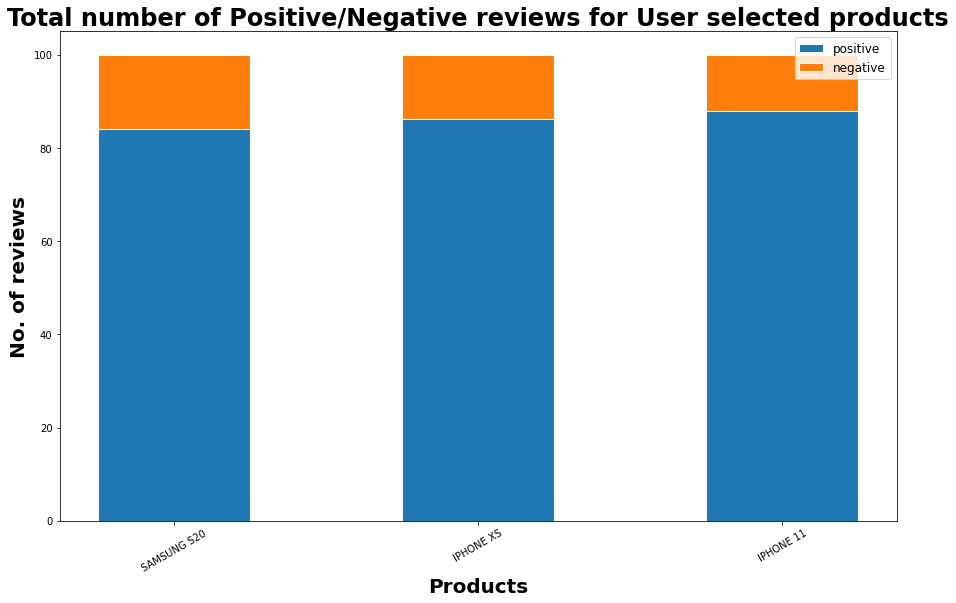

In [20]:
negative = []
positive = []
names = []

#Aggregating all products positive and negative reviews
for product in y_test_reviews:
    product = json.loads(product)
    negative.append(product['negative'])
    positive.append(product['positive'])
    names.append(unquote(product['productName'].upper()))
    
ticks =  list(range(0, len(y_test_reviews)))

plt.figure(figsize=(15,9))
plt.bar(ticks, positive, edgecolor='white', label='positive', width=0.5)
plt.bar(ticks, negative, bottom = positive, edgecolor='white', label='negative', width=0.5)
plt.xticks(ticks, names, rotation=30)
plt.xlabel('Products', fontSize=20, fontweight='bold')
plt.ylabel('No. of reviews', fontSize=20, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.title('Total number of Positive/Negative reviews for User selected products', fontsize=24, fontweight="bold")

plt.show()